In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import torch.nn.functional as F
import os
import numpy as np
import requests

from matplotlib import pyplot as plt
from pytorch_grad_cam import GradCAMElementWise


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE)

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)
print(torch.__version__)

Running on device: cuda
2.1.1+cu118


In [2]:
# some of this portion is from (i.e starting point): https://github.com/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb
# loading the normalization applied during training

mean, sd = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

normalize = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(), # mean and sd from pytorch
        transforms.Normalize(mean, sd),
    ]
)

# download train set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# download held out data into test set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)


test_loader = DataLoader(held_out, batch_size=256, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
import seaborn as sns


def accuracy(nn, dataLoader):
    nn.eval()
    num_correct = 0
    total = 0
    for inputs, targets in dataLoader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = nn(inputs) # get logits
        _, predicted = outputs.max(1) # select max index
        total += targets.size(0)
        num_correct += predicted.eq(targets).sum().item() # sum correct instances
    return num_correct / total


def evaluate(nn, dataLoader):
    nn.eval()
    total_correct = 0.0
    total_loss = 0.0
    total = 0
    allpreds=[]
    with torch.no_grad():
        for inputs, targets in dataLoader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = nn(inputs) # get logits
            loss = F.cross_entropy(outputs, targets)
            total += targets.size(0)
            preds = torch.argmax(outputs.detach(), dim=1)
            total_correct += (targets==preds).sum().item()
            total_loss += loss.detach()
            allpreds.extend(preds.cpu().tolist())
    pred_counts = [allpreds.count(label) for label in range(10)]
    ax = sns.barplot(x=np.arange(len(pred_counts)), y=pred_counts)
    ax.bar_label(ax.containers[0])
    plt.show()
    return total_correct/total, total_loss/total



In [4]:
class ResNet18_scratch(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = resnet18(weights=None, num_classes=num_classes)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [5]:
# download pre-trained weights, TODO: plug in trained weights from Nur
# using unlearning-challenge weights for now

pretrained_state_dict = torch.load("/home/bashlab/shouborno/ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location=DEVICE)
retrained_state_dict = torch.load("/home/bashlab/shouborno/ResNET18_CIFAR10_Pretrained_retrain_Class0_5_Epochs.pt", map_location=DEVICE)
scratch_unlearned_state_dict = torch.load("/home/bashlab/shouborno/ResNET18_CIFAR10_scratch_retrain_Class0_5_Epochs.pt", map_location=DEVICE)


# load model with pre-trained weights
model = ResNet18_scratch(num_classes=10)
model.load_state_dict(pretrained_state_dict)
model.to(DEVICE)
model.eval()

# retrained_unlearned_model = ResNet18_scratch(num_classes=10)
# retrained_unlearned_model.load_state_dict(retrained_state_dict)
# retrained_unlearned_model.to(DEVICE)
# retrained_unlearned_model.eval()

scratch_unlearned_model = ResNet18_scratch(num_classes=10)
scratch_unlearned_model.load_state_dict(scratch_unlearned_state_dict)
scratch_unlearned_model.to(DEVICE)
scratch_unlearned_model.eval()

print(f"Train accuracy: {100.0 * accuracy(model, train_loader)}%")
print(f"Test accuracy: {100.0 * accuracy(model, test_loader)}%")


Train accuracy: 96.88600000000001%
Test accuracy: 90.77%


In [6]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BATCH_SIZE = 256
forget_classes = [0]
num_classes = len(classes)

train_set_classes = {} # define dict: class -> class imgs
for i in classes:
    train_set_classes[i] = []
for img, label in train_set:
    train_set_classes[label].append((img, label))

test_set_classes = {}
for i in classes:
    test_set_classes[i] = []
for img, label in held_out:
    test_set_classes[label].append((img, label))

# number of retain samples from each class, needed for repair and impair step
# subset of D_retain
numRetainSamples = 1000
retainedSamples = []
for i in classes:
    if classes[i] not in forget_classes:
        # get first numRetainSamples from each class not in the forget set
        retainedSamples.extend(train_set_classes[i][:numRetainSamples])

# retain test set
retainTestSet = []
for classR in classes:
    if classR not in forget_classes:
        for img, label in test_set_classes[classR]:
            retainTestSet.append((img, label))

# forget test set
forgetTestSet = []
for classF in classes:
    if classF in forget_classes:
        for img, label in test_set_classes[classF]:
            forgetTestSet.append((img, label))

forgetSetTestLoader = DataLoader(forgetTestSet, BATCH_SIZE, num_workers=2)
retainSetTestLoader = DataLoader(retainTestSet, BATCH_SIZE, num_workers=2)

In [7]:
# Noise data
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)

    def forward(self):
        return self.noise

In [10]:
def fast_effective_unlearning(net, classesToForget, retainSamples):
    '''
    net: NN.module (i.e the neural network)
    classesToForget: List (i.e the list of classes to unlearn)
    retainSamples: List (i.e the (images, label_idx) sampled from D_retain)
    '''
    # Learn noise
    BATCH_SIZE = 256 # same as paper
    noises = {} # noise dict --> maps foget class to learnt noises (i.e Noise nn.module)
    IMG_SIZE = (3, 224, 224)
    L2_REG = 0.1 # same as in the paper

    print("Phase 1: Learning Noise for forget classes")

    net.eval() # freeze weights when generating noise
    for classF in classesToForget:
        print(f"Learning noise matrices for class = {classF}")
        noises[classF] = Noise(BATCH_SIZE, *IMG_SIZE).to(DEVICE)
        opt = torch.optim.Adam(noises[classF].parameters(), lr = 0.1, weight_decay=L2_REG) # same learning rate in the paper
        noises[classF].train(True)
        numEpochs = 5 # same as paper
        stepPerEpoch = 20 # same as in paper
        for epoch in range(numEpochs):
            total_loss = []
            for batch in range(stepPerEpoch):
                inputs = noises[classF]() # input set as noise matrix
                labels = torch.zeros(BATCH_SIZE).to(DEVICE) + classF # set all labels as class to forget
                labels = labels.long()
                outputs = net(inputs) # get outputs from trained nn
                loss = -F.cross_entropy(outputs, labels)
                opt.zero_grad()
                loss.backward()
                opt.step()
                total_loss.append(loss.cpu().detach().numpy())
        print("Loss: {}".format(np.mean(total_loss)))

    print("Phase 1 complete.")
    print("Forget Set Performance:", evaluate(net, forgetSetTestLoader))
    print("Retain Set Performance:", evaluate(net, retainSetTestLoader))
    print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")


    print("Phase 2: Impair")
    noiseData = []
    numBatches = 20 # number of times the noisy data is replicated, same as in paper

    for classF in classesToForget:
        for i in range(numBatches):
            batch = noises[classF]().cpu().detach()
            for i in range(batch[0].size(0)): # for each noise matrix in batch
                noiseData.append((batch[i], torch.tensor(classF))) # (noise matrix, class_num)
    # TODO: what if we randomized the labels for classF as well?

    retainSampleImpair = []
    for i in range(len(retainSamples)):
        retainSampleImpair.append((retainSamples[i][0].cpu(), torch.tensor(retainSamples[i][1]))) # data, label

    impairData = []
    impairData.extend(noiseData)
    impairData.extend(retainSampleImpair)
    impairLoader = torch.utils.data.DataLoader(impairData, batch_size=256, shuffle = True)
    impair_len = len(impairLoader.dataset)


    optimizer = torch.optim.Adam(net.parameters(), lr = 0.02)

    net.train() # set to training mode
    NUM_EPOCH_IMPAIR = 1 # same as in the paper
    for epoch in range(NUM_EPOCH_IMPAIR):
        total_correct = 0.0
        totalLoss = 0.0
        for impairData in impairLoader:
            inputs, labels = impairData
            inputs = inputs.to(DEVICE)
            labels = labels.clone().detach().to(DEVICE)

            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels) # cross entropy loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()
            preds = torch.argmax(outputs.detach(), dim=1)
            total_correct += (labels==preds).sum().item()
        print(total_correct,impair_len,total_loss)
        print(f"Epoch {epoch+1} | Train loss: {totalLoss/impair_len}, Training Acc:{total_correct*100/impair_len}%")


    print("Phase 2 complete.")
    print("Forget Set Performance:", evaluate(net, forgetSetTestLoader))
    print("Retain Set Performance:", evaluate(net, retainSetTestLoader))
    print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")


    print("Phase 3: Repair")

    repairLoader = torch.utils.data.DataLoader(retainSampleImpair, batch_size=256, shuffle = True)
    repairOtpm = torch.optim.Adam(net.parameters(), lr = 0.01)
    repair_len = len(repairLoader.dataset)

    NUM_EPOCH_REPAIR = 20
    net.train()
    for epoch in range(NUM_EPOCH_REPAIR):
        total_loss = 0.0
        total_correct = 0.0
        for data in repairLoader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.clone().detach().to(DEVICE)
            outputs = net(inputs)
            loss = F.cross_entropy(outputs, labels)
            repairOtpm.zero_grad()
            loss.backward()
            repairOtpm.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs.detach(), dim=1)
            total_correct += (labels==preds).sum().item()
        print(f"Epoch {epoch+1} | Train loss: {total_loss/repair_len}, Training Acc:{total_correct*100/repair_len}%")

    print("Phase 3 complete.")
    print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")
    net.eval()
    return net

Phase 1: Learning Noise for forget classes
Learning noise matrices for class = 0
Loss: -2.4145987033843994
Phase 1 complete.


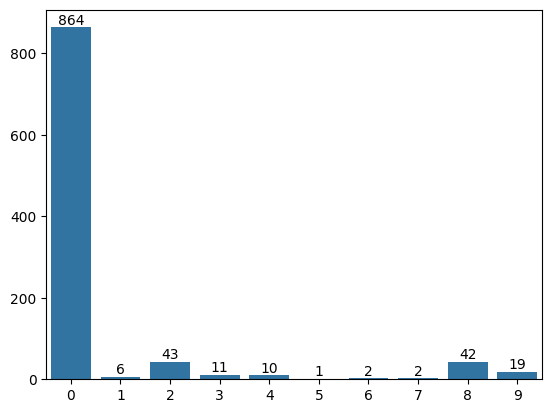

Forget Set Performance: (0.864, tensor(0.0016, device='cuda:0'))


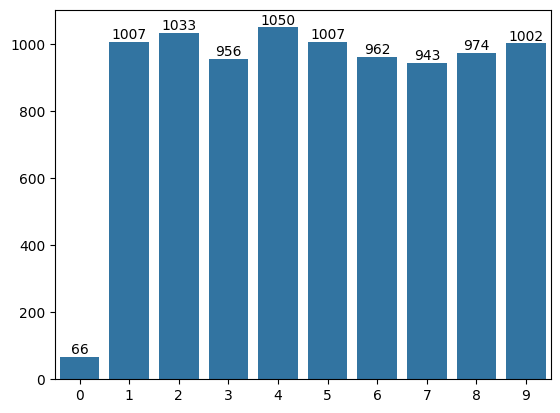

Retain Set Performance: (0.9125555555555556, tensor(0.0011, device='cuda:0'))
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Phase 2: Impair
1417.0 9060 [array(-2.4181178, dtype=float32), array(-2.417549, dtype=float32), array(-2.4170492, dtype=float32), array(-2.4165747, dtype=float32), array(-2.4161434, dtype=float32), array(-2.4157388, dtype=float32), array(-2.415378, dtype=float32), array(-2.4150405, dtype=float32), array(-2.4147315, dtype=float32), array(-2.4144275, dtype=float32), array(-2.4141512, dtype=float32), array(-2.4138906, dtype=float32), array(-2.4136443, dtype=float32), array(-2.4134183, dtype=float32), array(-2.413199, dtype=float32), array(-2.4129765, dtype=float32), array(-2.412765, dtype=float32), array(-2.4125755, dtype=float32), array(-2.4123843, dtype=float32), array(-2.4122162, dtype=float32)]
Epoch 1 | Train loss: 0.017059100457111467, Training Acc:15.640176600441501%
Phase 2 complete.


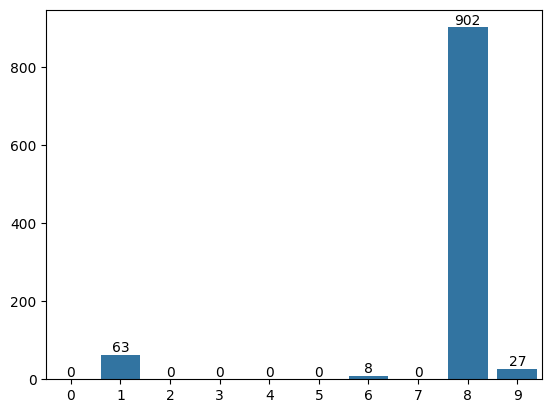

Forget Set Performance: (0.0, tensor(0.0195, device='cuda:0'))


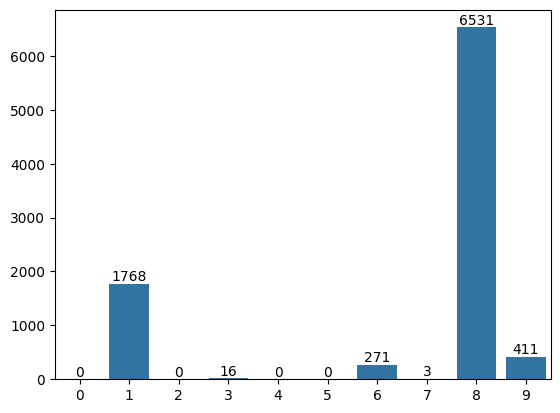

Retain Set Performance: (0.13477777777777777, tensor(0.0100, device='cuda:0'))
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Phase 3: Repair
Epoch 1 | Train loss: 0.01114426424768236, Training Acc:17.1%
Epoch 2 | Train loss: 0.009100772844420539, Training Acc:21.27777777777778%
Epoch 3 | Train loss: 0.00895115672217475, Training Acc:25.044444444444444%
Epoch 4 | Train loss: 0.008786315507358975, Training Acc:26.533333333333335%
Epoch 5 | Train loss: 0.008060889760653177, Training Acc:29.477777777777778%
Epoch 6 | Train loss: 0.008385382665528192, Training Acc:30.41111111111111%
Epoch 7 | Train loss: 0.008266575548383925, Training Acc:27.955555555555556%
Epoch 8 | Train loss: 0.007668059971597459, Training Acc:32.25555555555555%
Epoch 9 | Train loss: 0.007413489076826307, Training Acc:33.58888888888889%
Epoch 10 | Train loss: 0.006986538873778449, Training Acc:36.4%
Epoch 11 | Train loss: 0.006935447176297506, Training Acc:36.78888888888889%
Epoch 12 | Train loss: 0.006381521741549174, Training Acc:39

In [11]:
model_for_unlearning = ResNet18_scratch(num_classes=10)
model_for_unlearning.load_state_dict(pretrained_state_dict)
model_for_unlearning.to(DEVICE)

# perform unlearning
fast_unlearned_model = fast_effective_unlearning(model_for_unlearning, forget_classes, retainedSamples)

Scratch unlearned model performance metrics on Forget Class:


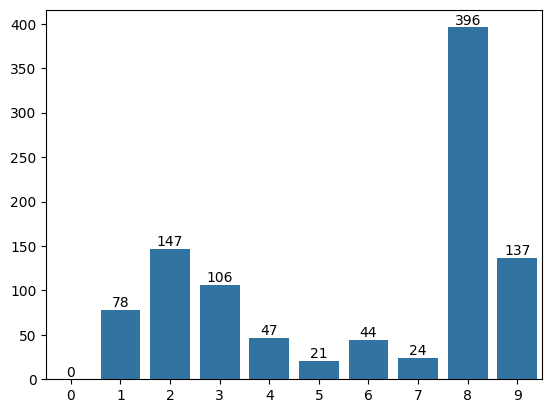

Accuracy: 0.0
Loss: 0.04543200880289078
Fast unlearned model performance metrics on Retain Class:


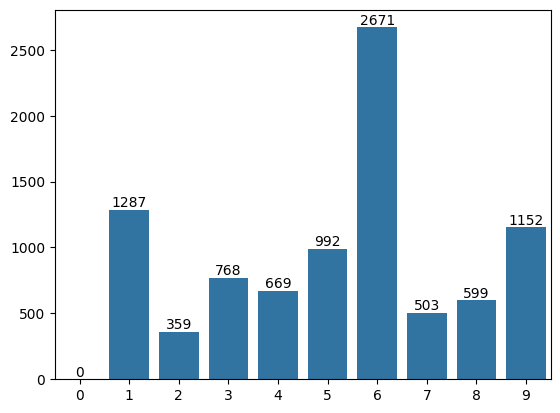

Accuracy: 0.4652222222222222
Loss: 0.006046180613338947
Fast unlearned model performance metrics on Forget Class:


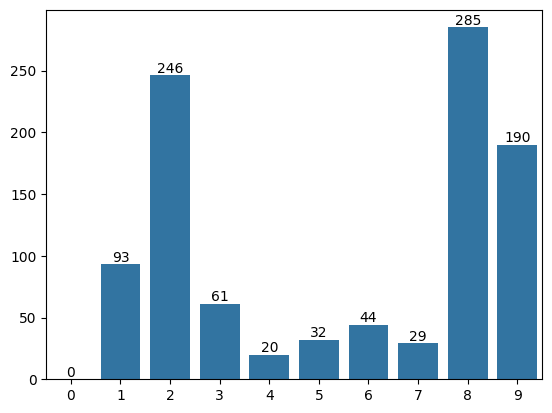

Accuracy: 0.0
Loss: 0.09552303701639175
Scratch unlearned model performance metrics on Retain Class:


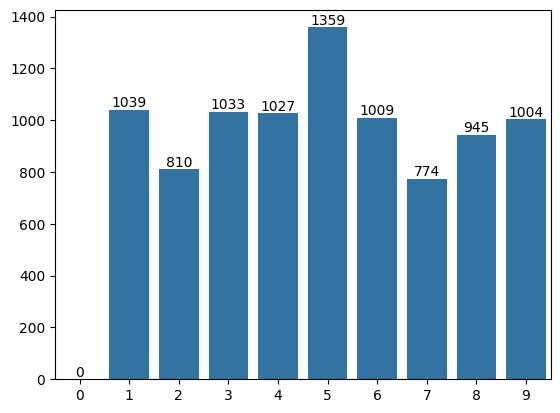

Accuracy: 0.8076666666666666
Loss: 0.0022684799041599035
Original model performance metrics on Retain Class:


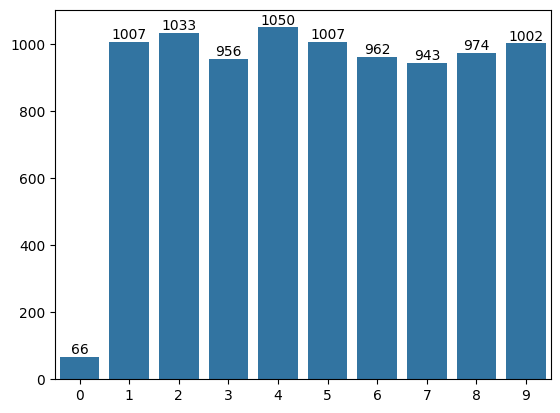

Accuracy: 0.9125555555555556
Loss: 0.0011383846867829561


In [12]:
# print("Retrained unlearned model performance metrics on Forget Class:")
# acc, loss = evaluate(retrained_unlearned_model, forgetSetTestLoader)
# print(f"Accuracy: {acc}")
# print(f"Loss: {loss}")


# print("Retrained unlearned model performance metrics on Retain Class:")
# acc2, loss2 = evaluate(retrained_unlearned_model, retainSetTestLoader)
# print(f"Accuracy: {acc2}")
# print(f"Loss: {loss2}")

print("Scratch unlearned model performance metrics on Forget Class:")
acc, loss = evaluate(scratch_unlearned_model, forgetSetTestLoader)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")


print("Fast unlearned model performance metrics on Retain Class:")
acc2, loss2 = evaluate(fast_unlearned_model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")

print("Fast unlearned model performance metrics on Forget Class:")
acc, loss = evaluate(fast_unlearned_model, forgetSetTestLoader)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")


print("Scratch unlearned model performance metrics on Retain Class:")
acc2, loss2 = evaluate(scratch_unlearned_model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")


print("Original model performance metrics on Retain Class:")
acc2, loss2 = evaluate(model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")


In [13]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image

# download train set
train_set_cifar100 = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

train_loader_cifar100 = DataLoader(train_set_cifar100, batch_size=5, shuffle=True, num_workers=2)

# download held out data into test set
held_out_cifar100 = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)


test_loader_cifar100 = DataLoader(held_out_cifar100, batch_size=5, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

original
0 0.9999999


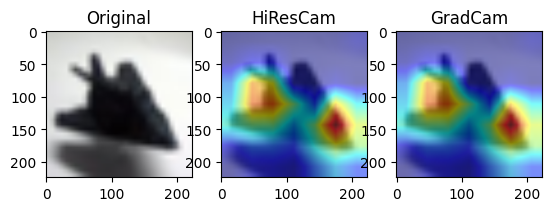

0 0.9999999


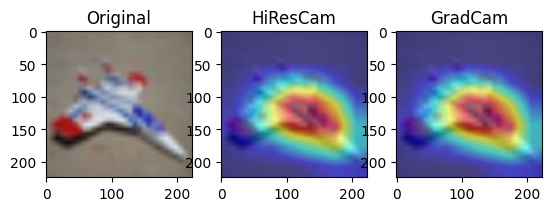

0 0.9999999


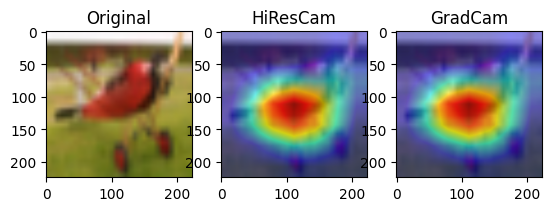

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


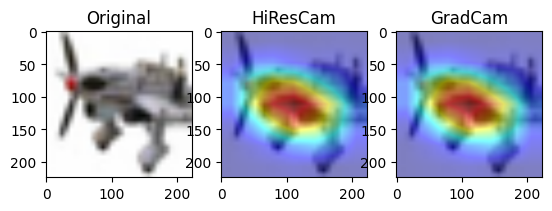

0 0.9999999


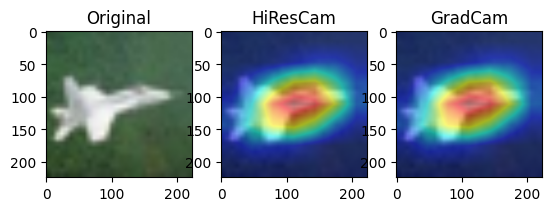

0 0.9999999


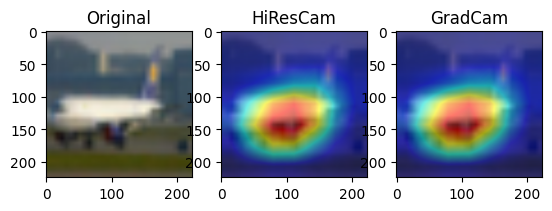

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


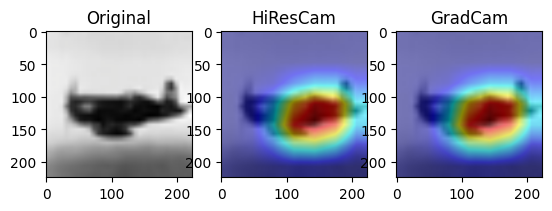

0 0.9999999


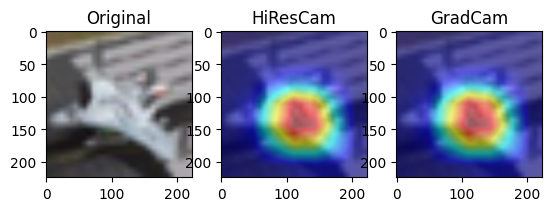

0 0.9999999


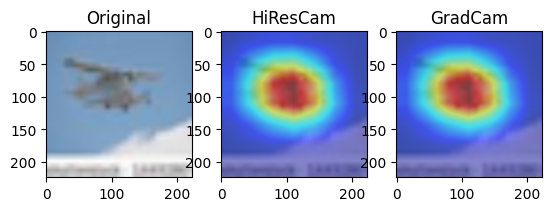

0 0.9999999


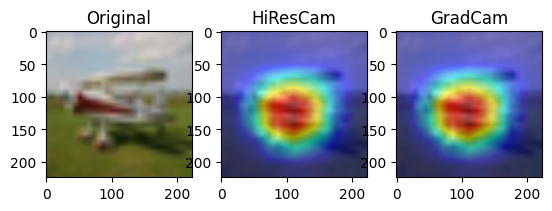

scratch
0 0.9999999


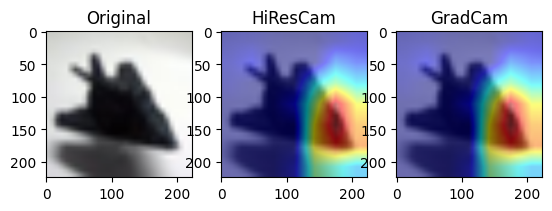

0 0.9999999


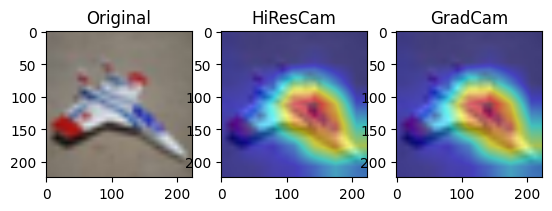

0 0.9999999


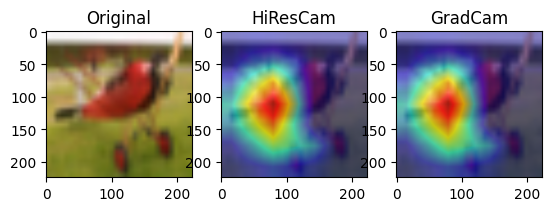

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


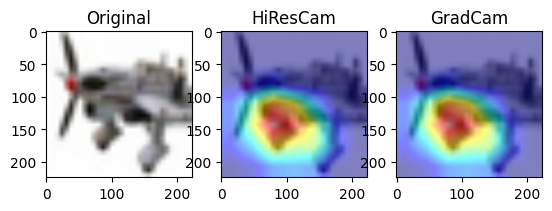

0 0.9999999


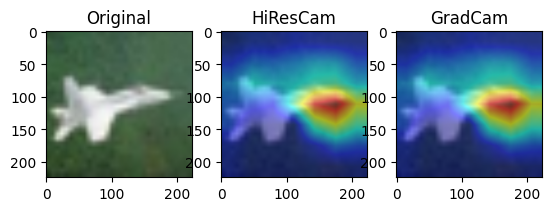

0 0.9999999


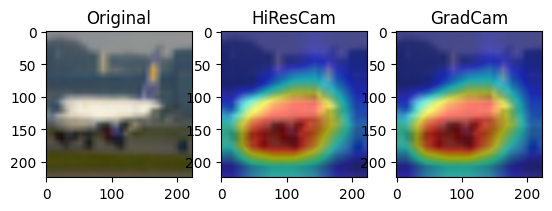

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


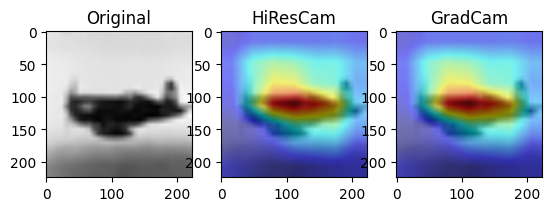

0 0.9999999


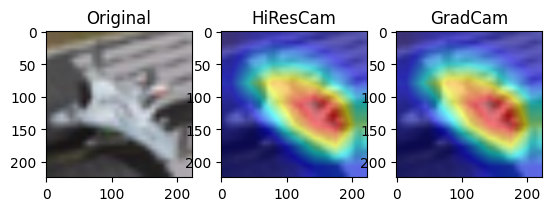

0 0.9999999


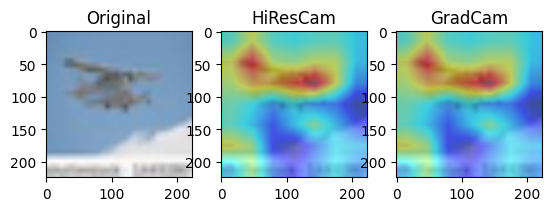

0 0.9999999


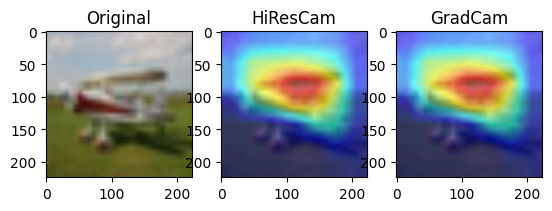

fast
0 0.9999999


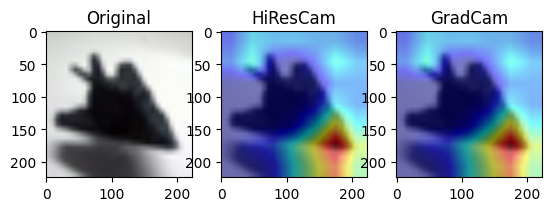

0 0.9999999


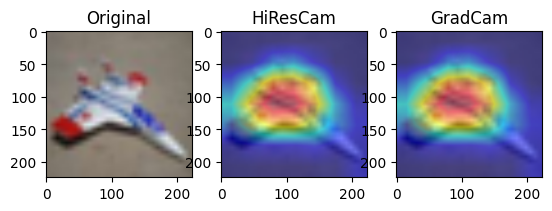

0 0.9999999


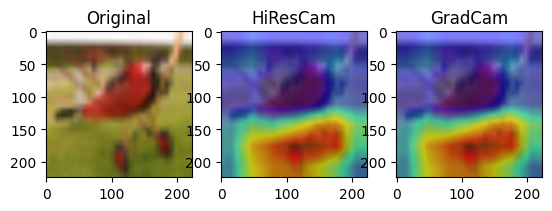

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


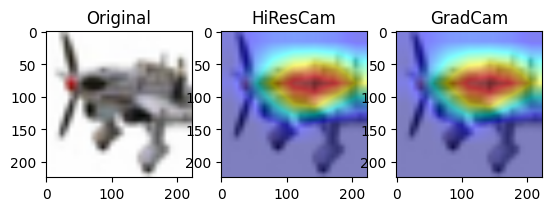

0 0.9999999


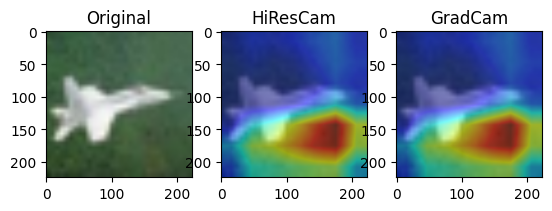

0 0.9999999


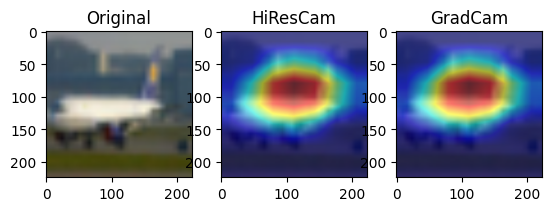

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


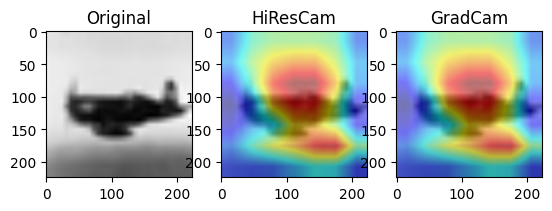

0 0.9999999


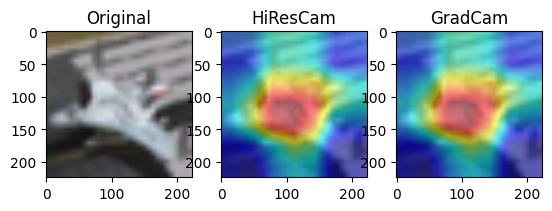

0 0.9999999


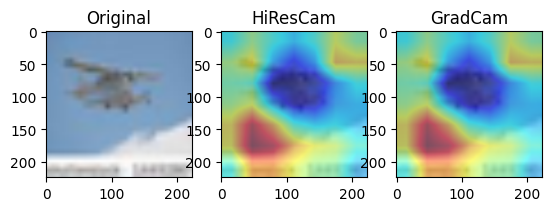

0 0.9999999


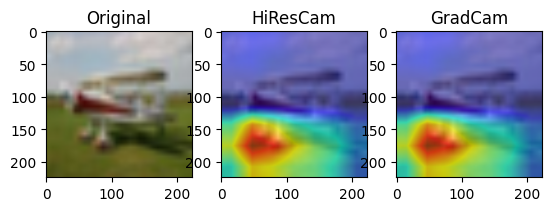

In [27]:
unnorm = UnNormalize(mean,sd)

def visualize_focus(model,test_data,acceptable_labels=[0,1,2,3,4,5,6,7,8,9],max_allowed=10):
  per_label_count = {}
  for label in acceptable_labels:
    per_label_count[label]=0
  target_layers = [model.base[-2][-1]]
  cam = HiResCAM(model=model, target_layers=target_layers, use_cuda=True)
  gradcam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
  for input_tensor, label in test_data:
    input_tensor=input_tensor.to(DEVICE)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    input_batch=input_tensor.unsqueeze(0)
    grayscale_cam = cam(input_tensor=input_batch, targets=None)
    gradcam_img = gradcam(input_tensor=input_batch, targets=None)
    if min(per_label_count.values())>max_allowed:
      break
    elif label not in acceptable_labels:
      continue
    else:
      per_label_count[label]+=1
      if per_label_count[label]>max_allowed:
        continue
    grayscale_cam = grayscale_cam[0, :]
    gradcam_img = gradcam_img[0,:]

    input_unnorm = unnorm(input_tensor.detach())
    input_numpy = input_unnorm.cpu().numpy()
    input_numpy = np.transpose(input_numpy, (1, 2, 0))
    visualization = show_cam_on_image(input_numpy, grayscale_cam, use_rgb=True)
    gradcam_vis = show_cam_on_image(input_numpy, gradcam_img, use_rgb=True)
    print(label, grayscale_cam.max())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(input_numpy)
    ax1.set_title("Original")
    ax2.imshow(visualization)
    ax2.set_title("HiResCam")
    ax3.imshow(visualization)
    ax3.set_title("GradCam")
    plt.show()

print("original")
visualize_focus(model,train_set,acceptable_labels=[0])
# print("retrain")
# visualize_focus(retrained_unlearned_model,train_set,acceptable_labels=[0])
print("scratch")
visualize_focus(scratch_unlearned_model,train_set,acceptable_labels=[0])
print("fast")
visualize_focus(fast_unlearned_model,train_set,acceptable_labels=[0])


Fast unlearned model performance metrics on train:


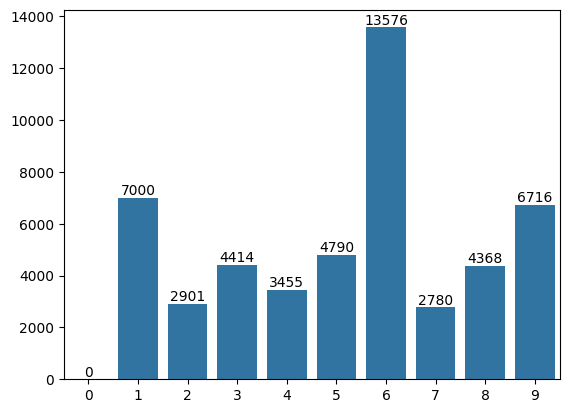

Accuracy: 0.42414
Loss: 0.01494279969483614


In [16]:
print("Fast unlearned model performance metrics on train:")
acc2, loss2 = evaluate(fast_unlearned_model, train_loader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")

In [20]:
neg_state_dict = torch.load("/home/bashlab/shouborno/neggrad_params.pth", map_location=DEVICE)

neg_model = ResNet18_scratch(num_classes=10)
neg_model.load_state_dict(neg_state_dict)
neg_model.to(DEVICE)
neg_model.eval()

ResNet18_scratch(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

Neg model performance metrics on Forget Class:


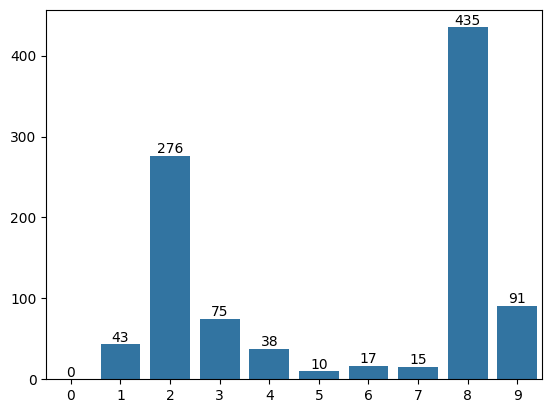

Accuracy: 0.0
Loss: 8.092586517333984
Neg model performance metrics on Retain Class:


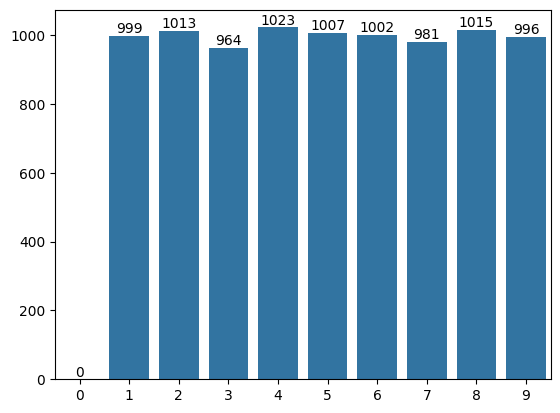

Accuracy: 0.9272222222222222
Loss: 0.0028703841380774975


In [21]:
print("Neg model performance metrics on Forget Class:")
acc, loss = evaluate(neg_model, forgetSetTestLoader)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")


print("Neg model performance metrics on Retain Class:")
acc2, loss2 = evaluate(neg_model, retainSetTestLoader)
print(f"Accuracy: {acc2}")
print(f"Loss: {loss2}")

0 0.9999999


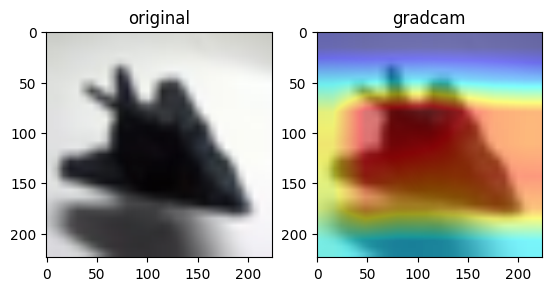

0 0.9999999


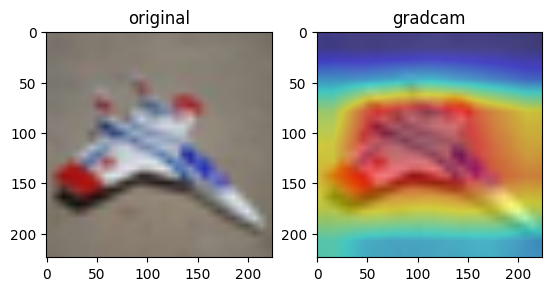

0 0.9999999


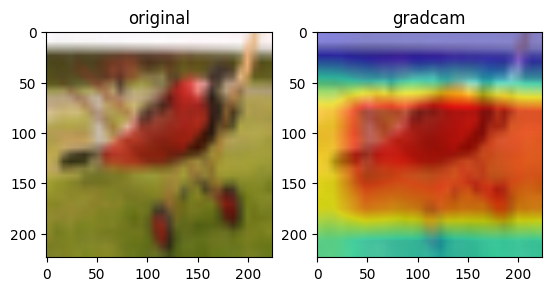

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


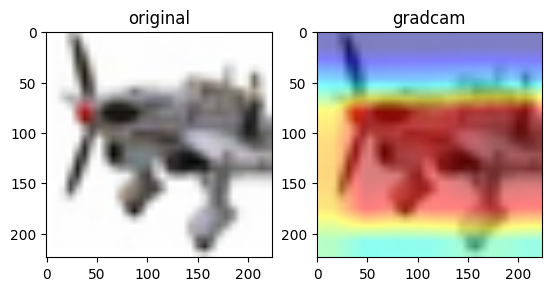

0 0.9999999


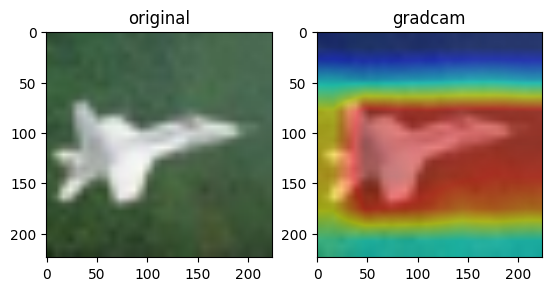

0 0.9999999


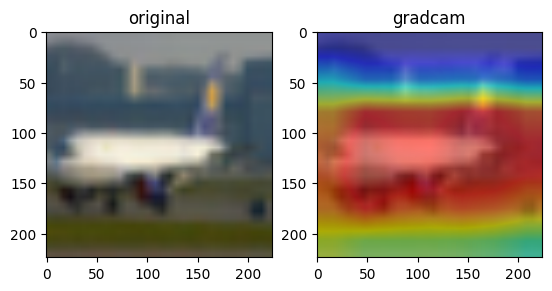

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9999999


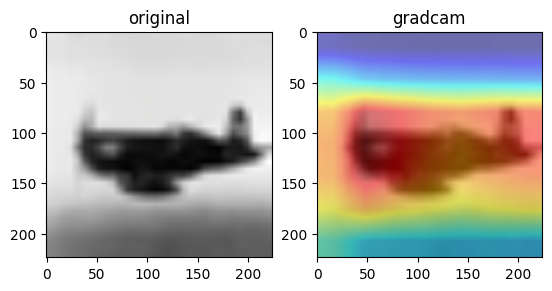

0 0.9999999


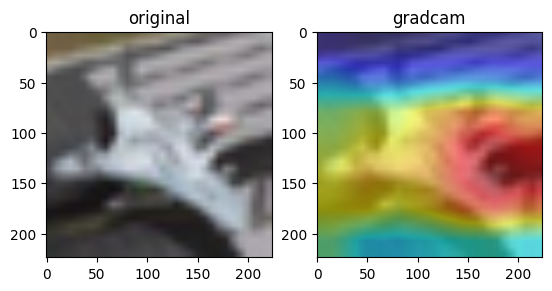

0 0.9999999


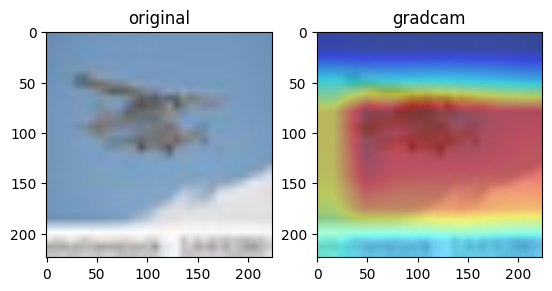

0 0.9999999


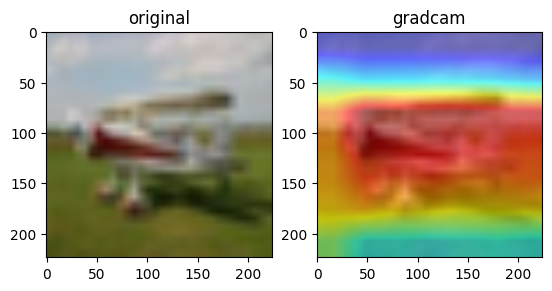

In [22]:
visualize_focus(neg_model,train_set,acceptable_labels=[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 0.9999999


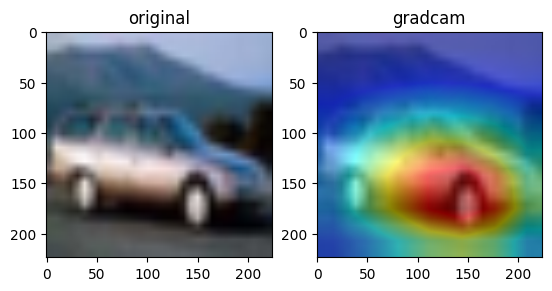

1 0.9999999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


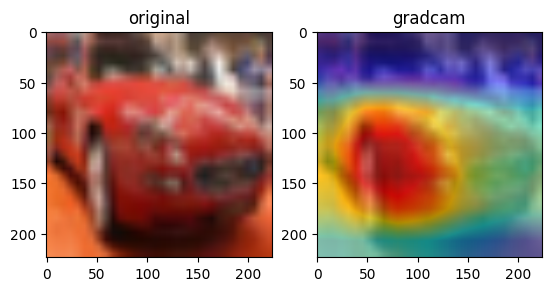

2 0.9999999


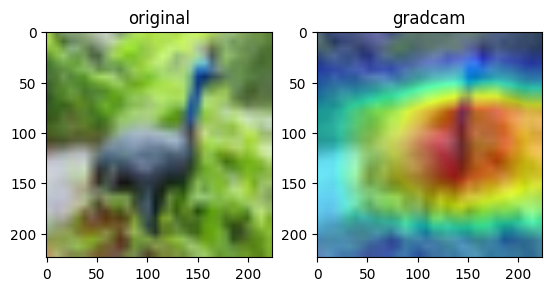

2 0.9999999


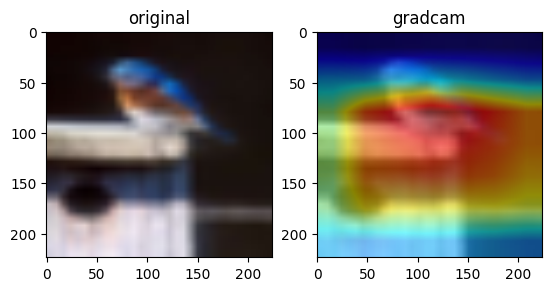

2 0.9999999


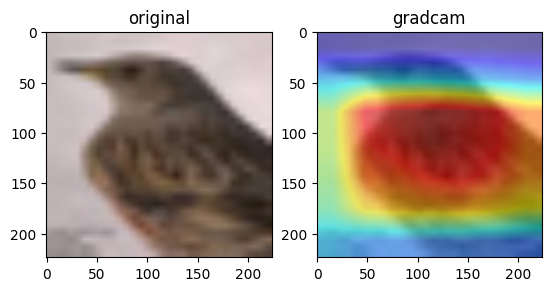

2 0.9999999


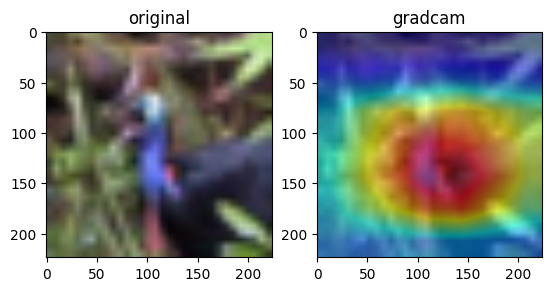

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 0.9999999


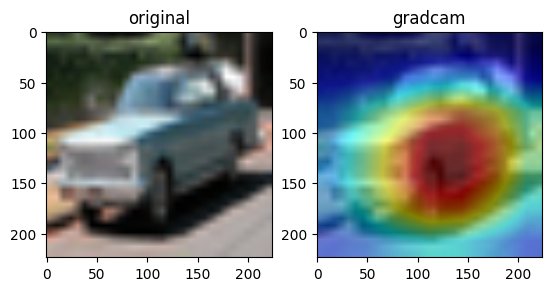

2 0.9999999


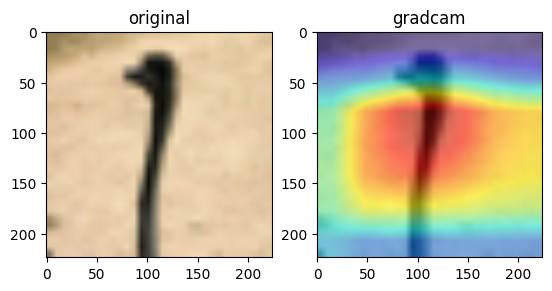

2 0.9999999


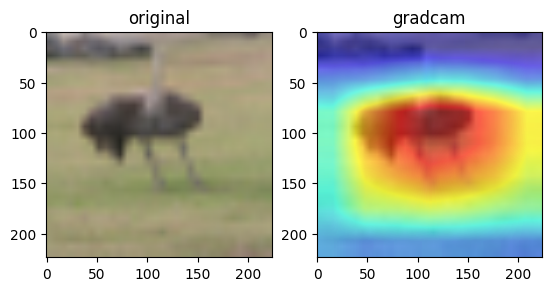

1 0.9999999


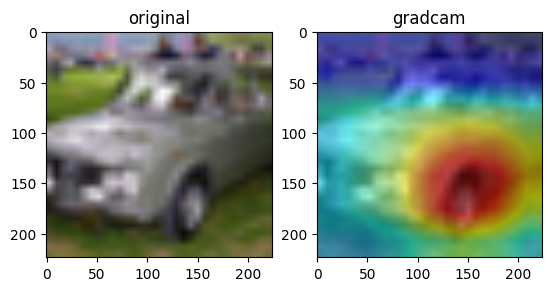

1 0.9999999


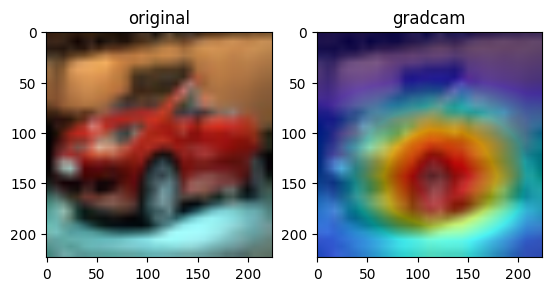

1 0.9999999


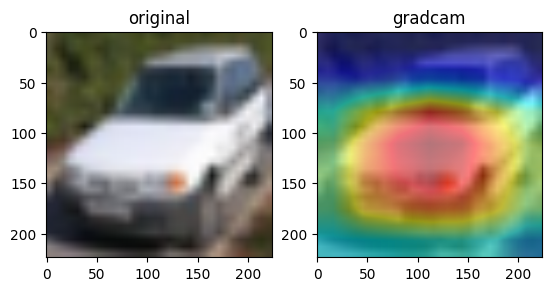

2 0.9999999


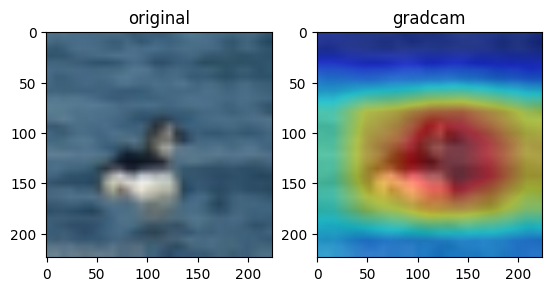

2 0.9999999


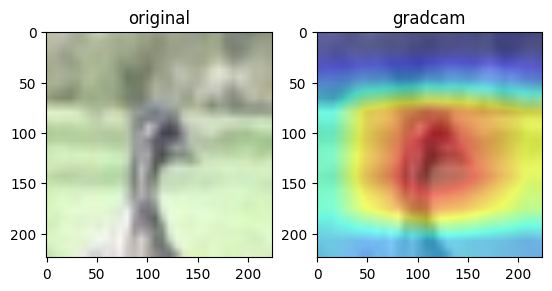

2 0.9999999


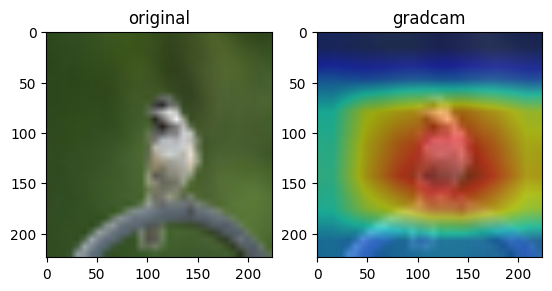

2 0.9999999


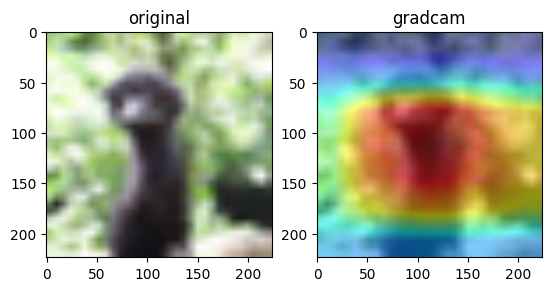

1 0.9999999


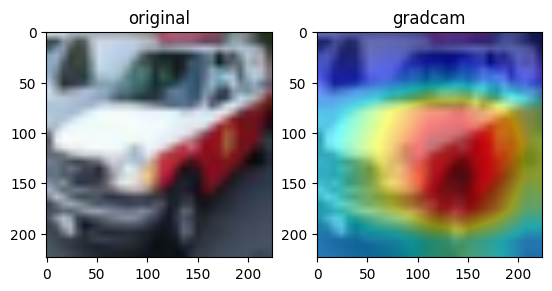

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 0.9999999


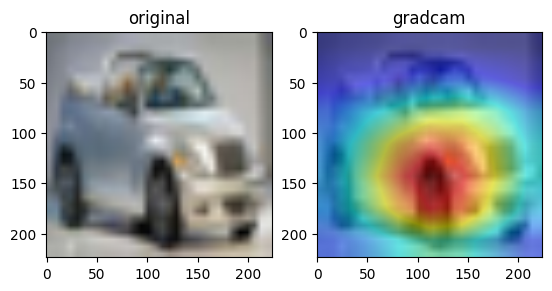

1 0.9999999


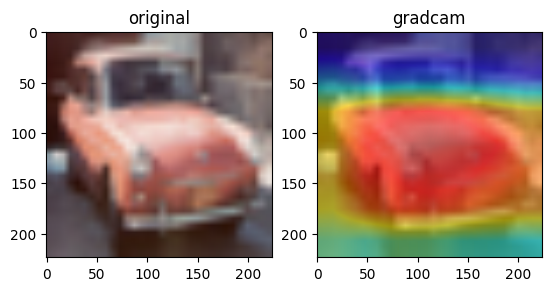

1 0.9999999


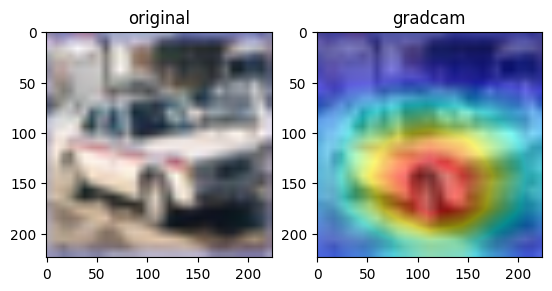

In [23]:
visualize_focus(neg_model,train_set,acceptable_labels=[1,2])